In [1]:
%matplotlib inline

# 去背神器 pytorch

![background_removal](../Images/background_removal.jpg)

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pylab
import PIL
from PIL import Image
import glob
import threading
import random
import math
import cv2
import os
import datetime
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

# 是否使用GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

![background_removal](../Images/supervise.png)

![background_removal](../Images/SuperviselyPerson.jpg)

In [3]:
imgs_path = glob.glob('../Data/ex05_train/imgs/' + '*.jpg')
mks_path = ['../Data/ex05_train/masks/' + os.path.basename(i)[:-4] + '.png' for i in imgs_path]
print(len(imgs_path))
print(len(mks_path))
print(imgs_path[:5])

5711
5711
['../Data/ex05_train/imgs\\ache-adult-depression-expression-41253.jpg', '../Data/ex05_train/imgs\\active-activity-ball-exercise-41213.jpg', '../Data/ex05_train/imgs\\active-athletic-exercise-female-40974.jpg', '../Data/ex05_train/imgs\\active-cold-female-girl-41371.jpg', '../Data/ex05_train/imgs\\adorable-baby-beautiful-boy-41000.jpg']


In [4]:
#圖片轉向量
def img2array(img: Image):
    arr = np.array(img).astype(np.float32)
    arr=arr.transpose(2, 0, 1) #轉成CHW
    arr=np.ascontiguousarray(arr)
    return arr[::-1] #顏色排序為BGR

#向量轉圖片
def array2img(arr: np.ndarray):
    arr =arr[::-1]#轉成RGB
    sanitized_img = np.maximum(0, np.minimum(255, np.transpose(arr, (1, 2, 0))))#轉成HWC
    img = Image.fromarray(sanitized_img.astype(np.uint8))
    return img



#把圖片並列列印出來
def tile_rgb_images(pred, label, truth, row=3, col=3):
    fig = pylab.gcf()
    fig.set_size_inches(20, 18)

    fig.set_size_inches(col * 2, row * 2)
    pylab.clf()
    pylab.ioff()  # is not None:
    for m in range(row * col):
        pylab.subplot(row, col, m + 1)
        if m % 3 == 0:
            img = array2img(truth[int(m/ 3)]*pred[int(m / 3)]+np.ones((3,256,256))*120*(1-pred[int(m / 3)]))
        elif m % 3 == 1:

            img = array2img(truth[int(m/ 3)]*label[int((m - 1) / 3)]+np.ones((3,256,256))*120*(1-label[int(m / 3)]))
        else:
            img = array2img(truth[int((m - 2) / 3)])
        pylab.imshow(img, interpolation="nearest", animated=True)
        pylab.axis("off")

In [5]:
#數據增強處理函數

#隨機裁切
def random_crop(image,mask):
    min_len=min(image.width,image.height)
    #print(min_len)
    scale=1.
    if min_len<256 or min_len>256*1.5:
        scale=np.random.choice(np.arange(256./min_len,1.5*256./min_len,0.1))
    image=image.resize((int(image.width*scale)+2,int(image.height*scale)+2),Image.ANTIALIAS)
    image=img2array(image)
    mask=mask.resize((int(mask.width*scale)+2,int(mask.height*scale)+2), Image.NEAREST)
    mask=img2array(mask)
    #print('image:{0}'.format(image.shape))
    #print('mask:{0}'.format(mask.shape))
    offset_x=random.choice(range(0,image.shape[2]-256))
    offset_y=random.choice(range(0,image.shape[1]-256))
    #print('offset_x:{0}'.format(offset_x))
    #print('offset_y:{0}'.format(offset_y))
    image=image[:,offset_y:offset_y+256,offset_x:offset_x+256]
    mask=mask[:,offset_y:offset_y+256,offset_x:offset_x+256]
    #print('crop image:{0}'.format(image.shape))
    #print('crop mask:{0}'.format(mask.shape))
    return image,mask[0,:,:]
        
#隨機加入標準常態分配的噪聲
def add_noise(image):
    noise=np.random.standard_normal(image.shape)*np.random.choice(np.arange(-15,15))
    image=np.clip(image+noise,0,255)
    return image

#調整明暗
def adjust_gamma(image,gamma=1.8):
    image = image.transpose([1, 2, 0])
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    cv2.LUT(image.astype(np.uint8), table)
    image = image.transpose([2, 0, 1])
    return image

#模糊
def adjust_blur(image,gamma=1.8):
    image = image.transpose([1, 2, 0])
    image=cv2.blur(image, (3, 3))
    image = image.transpose([2, 0, 1])
    return image



In [6]:
idx=0
idxs=np.arange(len(imgs_path))
np.random.shuffle(idxs)

def get_next_minibatch(minibatch_size=8, is_train=True):
    global idx,idxs
    features=[]
    masks=[]
    sizes=[]
    while len(features)<minibatch_size:
        im,mk=random_crop(Image.open(imgs_path[idxs[idx]]),Image.open(mks_path[idxs[idx]]))
        
        #print(im.shape),print(mk.shape)
        if is_train:
            if random.randint(0,10)%3==0:
                im=add_noise(im)

            if random.randint(0,10)%5<=1: #水平翻轉
                im=im[:,:, ::-1]
                mk=mk[:, ::-1]

            if random.randint(0,10)%3==0:
                im=adjust_blur(im)
                
            if random.randint(0,10)%2==0: #明暗
                gamma=np.random.choice(np.arange(0.6, 1.4, 0.05))
                img=adjust_gamma(im,gamma)
            
        
        mk[mk>0]=1

        #print(decode_mk.shape)
        

        features.append(im/255.0)
        masks.append(mk)
        idx+=1
        if idx>=len(imgs_path)-1:
            idx=0
            np.random.shuffle(idxs)
    return np.asarray(features).astype(np.float32),np.asarray(masks).astype(np.int64)
                                
features_x,mask_y=get_next_minibatch(2)
print(features_x.shape)
print(mask_y.shape)

(2, 3, 256, 256)
(2, 256, 256)


![background_removal](../Images/deeplabv3.jpg)

![background_removal](../Images/aspp.jpg)

In [7]:
class ASPP(nn.Module):
    def __init__(self,in_channel=512,depth=256):
        super().__init__()
        # global average pooling : init nn.AdaptiveAvgPool2d ;also forward torch.mean(,,keep_dim=True)
        self.mean = nn.AdaptiveAvgPool2d((4,4))
        self.conv = nn.Sequential(nn.Conv2d(in_channel,depth,1,1),nn.ReLU(inplace=True))
        self.atrous_block1  = nn.Sequential(nn.Conv2d(in_channel,depth,1,1),nn.ReLU(inplace=True))
        self.atrous_block6  = nn.Sequential(nn.Conv2d(in_channel,depth,3,1,padding=6,dilation=6),nn.ReLU(inplace=True))
        self.atrous_block12 = nn.Sequential(nn.Conv2d(in_channel,depth,3,1,padding=12,dilation=12),nn.ReLU(inplace=True))
        self.atrous_block18 = nn.Sequential(nn.Conv2d(in_channel,depth,3,1,padding=18,dilation=18),nn.ReLU(inplace=True))
        self.conv_1x1_output= nn.Sequential(nn.Conv2d(depth*5,depth,1,1),nn.ReLU(inplace=True))
    def forward(self,x):
        size = x.shape[2:]
        image_features = self.mean(x)
        image_features = self.conv(image_features)
        image_features = F.upsample(image_features,size=size,mode='bilinear',align_corners=True)
        atrous_block1  = self.atrous_block1(x)
        atrous_block6  = self.atrous_block6(x)
        atrous_block12 = self.atrous_block12(x)
        atrous_block18 = self.atrous_block18(x)
        net = self.conv_1x1_output(torch.cat([image_features,atrous_block1,atrous_block6,atrous_block12,atrous_block18],dim=1))
        return net

In [8]:
class Deeplab_v3(nn.Module):
    # in_channel = 3 fine-tune
    def __init__(self,class_number=2, fine_tune=True):
        super().__init__()
        encoder = torchvision.models.resnet18(pretrained=fine_tune)
        self.start = nn.Sequential(encoder.conv1,encoder.bn1, encoder.relu)
        self.maxpool = encoder.maxpool
        self.low_feature = nn.Sequential(nn.Conv2d(256,64,1,1),nn.ReLU(inplace=True)) # no bn, has bias and relu
        self.layer1 = encoder.layer1
        self.layer2 = encoder.layer2
        self.layer3 = encoder.layer3
       
        
        self.aspp = ASPP(in_channel=256, depth=256)
        self.conv_cat = nn.Sequential(nn.Conv2d(256+64,256,3,1,padding=1),nn.ReLU(inplace=True))
        self.conv_cat1 = nn.Sequential(nn.Conv2d(256,256,3,1,padding=1),nn.ReLU(inplace=True))
        self.conv_cat2 = nn.Sequential(nn.Conv2d(256,256,3,1,padding=1),nn.ReLU(inplace=True))
        self.score = nn.Conv2d(256,class_number,1,1)# no relu and first conv then upsample, reduce memory
    def forward(self,x):
        size1 = x.shape[2:]# need upsample input size
        x  =self.start(x)
        x  =self.layer1(x)
        x = self.layer2(x)#4, 128, 64, 64
        xm = self.layer3(x)#256, 32, 32
        x = self.aspp(xm) #4, 256, 8, 8
        low_feature = self.low_feature(xm)
       
        size2 = low_feature.shape[2:]
        conv_cat  = self.conv_cat( torch.cat([low_feature,x],dim=1) )
        conv_cat1 = self.conv_cat1(conv_cat)
        conv_cat2 = self.conv_cat2(conv_cat1)
        score_small = self.score(conv_cat2)
        score = F.upsample(score_small,size=size1,mode='bilinear',align_corners=True)
        return score

In [9]:
num_epochs=2
minibatch_size=8
learning_rate =1e-5 # 學習速率 
model =Deeplab_v3(class_number=2, fine_tune=True)
if os.path.exists('Models/deeplabv3_pytorch.cnn'):
    model=torch.load('Models/deeplabv3_pytorch.cnn')
    print('載入既有模型累積訓練!!')
model=model.to(device)



optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=5e-5)
criterion=nn.CrossEntropyLoss()  

載入既有模型累積訓練!!


In [10]:
print('epoch start')
for epoch in range(num_epochs):
    mbs = 0
    trn_loss = 0
    trn_intersection= 0
    trn_union = 0
    while mbs < 500:
        raw_features, raw_mask= get_next_minibatch(minibatch_size)
        #讀取數據
        input, target = torch.from_numpy(raw_features), torch.from_numpy(raw_mask)
        #將numpy轉為variable
        input, target = Variable(input), Variable(target)
        #轉換為cuda
        input, target = input.to(device), target.to(device) #使用GPU or CPU
        output = model(input)
        loss = criterion(output, target)

        optimizer.zero_grad()#這句一定要放在loss.backward()之前
        loss.backward()
        optimizer.step()
        trn_loss += loss.data.item()
        
        pred =np.argmax(output.cpu().detach().numpy(),1)
        mask =raw_mask
        intersection=np.sum(np.equal(pred,mask)*np.greater(mask,0))
        union=np.sum(np.greater(pred+mask,0))
        trn_intersection+=intersection
        trn_union+=union


        if mbs % 100 == 0:
            print("Epoch: {}/{} ".format(epoch + 1, num_epochs),
                  "Step: {} ".format(mbs),
                  "Loss: {:.4f} ".format(trn_loss/100.),
                  "Iou: {:.3%}".format(trn_intersection/trn_union))
            trn_loss=0
            trn_intersection=0
            trn_union=0
            torch.save(model, 'Models/deeplabv3_pytorch.cnn')
        mbs += 1

    torch.save(model, 'Models/deeplabv3_pytorch.cnn')

    

epoch start


C:\Anaconda3\lib\site-packages\torch\nn\functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Epoch: 1/2  Step: 0  Loss: 0.0025  Iou: 67.102%


C:\Anaconda3\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type Deeplab_v3. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Anaconda3\lib\site-packages\torch\serialization.py:250: UserWarning: Couldn't retrieve source code for container of type ASPP. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 1/2  Step: 100  Loss: 0.3579  Iou: 65.982%
Epoch: 1/2  Step: 200  Loss: 0.2965  Iou: 70.818%
Epoch: 1/2  Step: 300  Loss: 0.2651  Iou: 72.695%
Epoch: 1/2  Step: 400  Loss: 0.2628  Iou: 73.301%
Epoch: 2/2  Step: 0  Loss: 0.0030  Iou: 77.131%
Epoch: 2/2  Step: 100  Loss: 0.2388  Iou: 75.753%
Epoch: 2/2  Step: 200  Loss: 0.2484  Iou: 74.691%
Epoch: 2/2  Step: 300  Loss: 0.2238  Iou: 76.337%
Epoch: 2/2  Step: 400  Loss: 0.2266  Iou: 78.144%


C:\Anaconda3\lib\site-packages\torch\nn\functional.py:2351: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


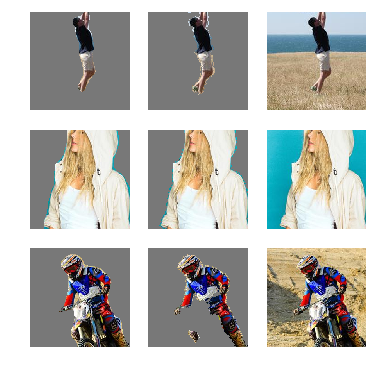

In [13]:
raw_features, raw_mask= get_next_minibatch(4,False)
#讀取數據
input, target = torch.from_numpy(raw_features), torch.from_numpy(raw_mask)
#將numpy轉為variable
input, target = Variable(input), Variable(target)
#轉換為cuda
input, target = input.to(device), target.to(device) #使用GPU or CPU
output = model(input)

pred =np.argmax(output.cpu().detach().numpy(),1)
tile_rgb_images(pred, raw_mask, raw_features*255., row=3, col=3)